# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in (0,1)\times (0,1)\\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}


In [219]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

## Initializing the PINN

In [220]:
from utils import data_path

file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
xpinn = XPINN(file, np.tanh)

We visualize the points of the domain decomposition.

(299, 2)
(40, 2)
(101, 2)
(40, 2)


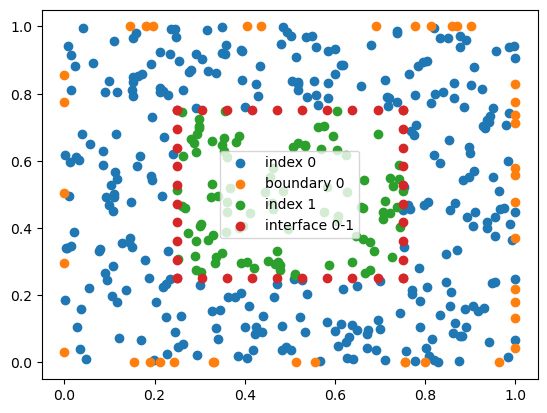

In [221]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the loss function
We create a base function for initializing the boundary loss functions, which is relatively simple in this case. 

In [222]:
from typing import Callable
from type_util import Params

LFunc = Callable[[Params, dict[str, Array]], Array]


def boundary_loss_factory(index: int, target: float | Array) -> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = xpinn.PINNs[index].v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss

In [223]:
def interior_loss_factory(index: int, rhs: float) -> LFunc:
    model = xpinn.PINNs[index].model

    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) - rhs

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

In [224]:
# args = xpinn.main_args[0]
# params = xpinn.PINNs[0].params

# args

In [225]:
# model = xpinn.PINNs[0].model
# hess = lambda params: hessian(lambda x: model(params, x))
# residual = lambda params, x: (np.trace(hess(params)(x)[0] - 1)) ** 2
# v_residual = vmap(residual, (None, 0))

# point = args["interior"][0]
# hess(params)(point)
# np.trace(hess(params)(point)[0] - 1)
# np.trace(hess(params)(point)[0]) - 1

Setting the boundary and interior loss

In [226]:
p0, p1 = xpinn.PINNs

p0.boundary_loss = boundary_loss_factory(0, 0)


p0.interior_loss = interior_loss_factory(0, 0.0)  # implementing rhs
p1.interior_loss = interior_loss_factory(1, 1.0)

Setting the interface loss

In [227]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((pi.v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 200 * (res_ij + avg_ij)

    return interface_loss

In [228]:
p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

In [229]:
for p in xpinn.PINNs:
    p.create_loss()

In [230]:
shapes = [[2] + [20] * 9 + [1], [2] + [20] * 9 + [1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=0.0001)

    pinn.init_params(shape, optimizer)

In [231]:
n_iter = 20000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 20000: Total loss = 401.00860595703125
10.00% iter = 2000 of 20000: Total loss = 1.9961390495300293
20.00% iter = 4000 of 20000: Total loss = 1.0798726081848145
30.00% iter = 6000 of 20000: Total loss = 0.5439229011535645
40.00% iter = 8000 of 20000: Total loss = 0.08342467993497849
50.00% iter = 10000 of 20000: Total loss = 0.04169299453496933
60.00% iter = 12000 of 20000: Total loss = 0.03514016419649124
70.00% iter = 14000 of 20000: Total loss = 0.017075499519705772
80.00% iter = 16000 of 20000: Total loss = 0.012810733169317245
90.00% iter = 18000 of 20000: Total loss = 0.011692823842167854
100.00% iter = 20000 of 20000: Total loss = 0.010711293667554855


Text(0.5, 1.0, 'Loss per Pinn over 20000 epochs')

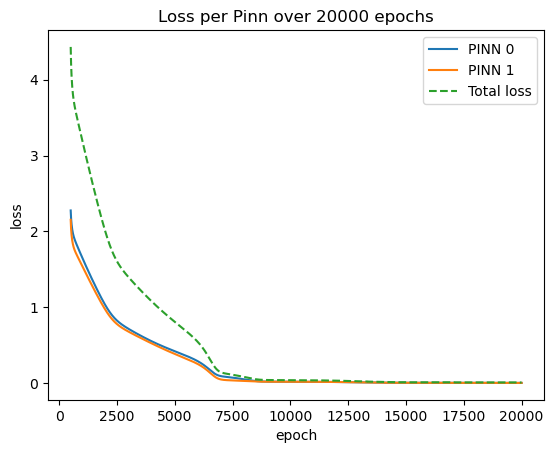

In [240]:
a_losses = np.asarray(losses).T
t_0 = 500
t_end = 20000
t = np.arange(t_0, t_end)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

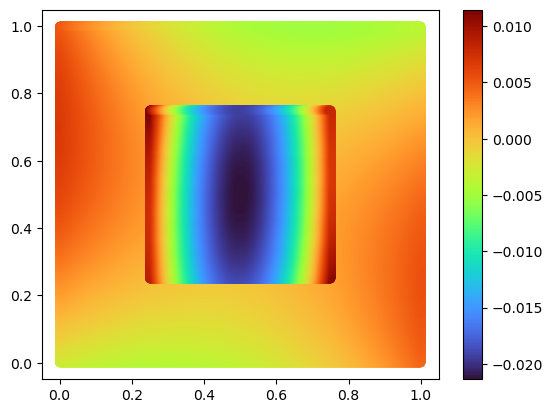

In [233]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()
# min_, max_ = 0, 1

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()

In [236]:
for key, val in xpinn.main_args.items():
    for k2, v2 in val.items():
        print(key, k2, v2.shape)

0 boundary (40, 2)
0 interior (299, 2)
0 interface 01 (40, 2)
0 interface res 1 (40,)
0 interface val 1 (40, 1)
1 boundary (0,)
1 interior (101, 2)
1 interface 01 (40, 2)
1 interface res 0 (40,)
1 interface val 0 (40, 1)
